This notebook demonstrates a process for analyzing ideological patterns within a text corpus using Latent Semantic Analysis (LSA) and a custom ideological embedding model. The main steps include:

Loading and Preprocessing Data: Reads a text corpus from a file, processes it for analysis.
Text Vectorization: Transforms the text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words.
Latent Semantic Analysis (LSA): Applies LSA to reduce dimensionality and identify underlying topics within the text corpus.
Ideological Embeddings Simulation: Simulates user interactions and ideological embeddings using custom matrices, updating these matrices iteratively based on observed and unobserved interactions.
Visualization: Normalizes and visualizes the ideological embeddings to help interpret and understand the positions of different users or documents in the ideological space.
Key Components:

Text Vectorization: Converts text into numerical vectors using TF-IDF.
Dimensionality Reduction: Uses LSA to extract topics and reduce feature dimensions.
Ideological Model Training: Implements a custom model to refine ideological embeddings based on simulated user interactions.
Visualization: Plots the resulting embeddings to visualize ideological distributions.

In [16]:
pip install numpy matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

Load and Preprocess the Text Corpus

In [18]:
# Load the corpus from the file
with open("ideological_corpus.txt", "r") as f:
    corpus = f.readlines()

# Display the first few lines of the corpus
corpus[:5]

['Support for Israeli settlements in the West Bank is crucial for security.\n',
 'Palestinian statehood should be recognized and supported by the international community.\n',
 'Economic cooperation between Israel and Palestine can lead to peace.\n',
 'Military action is necessary to protect Israeli borders from threats.\n',
 'Human rights abuses against Palestinians must be addressed by global organizations.\n']

Vectorize the Corpus Using TF-IDF

In [19]:
# Vectorize the corpus using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)

# Display the shape of the TF-IDF matrix
X.shape

(70, 291)

Perform LSA

In [20]:
# Number of topics  we want to identify
K = 3

# Perform LSA for dimensionality reduction and topic modeling
lsa = TruncatedSVD(n_components=K, random_state=0)
X_topics = lsa.fit_transform(X)

# Display the explained variance ratio
lsa.explained_variance_ratio_

array([0.01772322, 0.02266115, 0.02069994])

Analyze Topics

In [21]:
# Get the top words for each topic
topic_words = lsa.components_

# Display the topic words for each topic
print("Topic words per topic:")
for i, topic_dist in enumerate(topic_words):
    topic_words_list = [vectorizer.get_feature_names_out()[j] for j in topic_dist.argsort()[:-10 - 1:-1]]
    print(f"Topic {i}: {', '.join(topic_words_list)}")


Topic words per topic:
Topic 0: economic, growth, international, crucial, lead, trade, agreements, offers, opportunities, urbanization
Topic 1: necessary, government, protect, energy, surveillance, privacy, action, maintain, military, prevent
Topic 2: rights, public, essential, education, human, reduce, reform, free, cultural, society


Simulate user network and Ideological Embeddings

In [22]:
# Number of users (V)
V = 30

# Simulated user interactions and network
D = [np.random.choice(range(V), size=np.random.randint(1, V), replace=False) for _ in range(len(corpus))]
E = np.random.randint(0, 2, (V, V))

# Initialize 𝜙 (polarities) and 𝜃 (interests) as |V| x K matrices
phi = np.random.rand(V, K)
theta = np.random.rand(V, K)

# Number of epochs and learning rate
epochs = 10
learning_rate = 0.01


Define and Train Model

In [23]:
def alignment_probability(u, v, k):
    return phi[u, k] * phi[v, k] + (1 - phi[u, k]) * (1 - phi[v, k])

for epoch in range(epochs):
    for i in range(len(corpus)):
        for v in D[i]:
            for u in np.where(E[v] == 1)[0]:  # Users u that follow v
                if u in D[i]:
                    for k in range(K):
                        gradient_phi = X_topics[i, k] * theta[u, k] * (phi[v, k] - phi[u, k])
                        gradient_theta = X_topics[i, k] * alignment_probability(u, v, k)
                        phi[u, k] += learning_rate * gradient_phi
                        theta[u, k] += learning_rate * gradient_theta

            # Negative sampling for unobserved activations
            unobserved_users = np.setdiff1d(range(V), D[i])
            sample_size = min(len(unobserved_users), len(D[i]))
            sampled_unobserved_users = np.random.choice(unobserved_users, size=sample_size, replace=False)
            for u in sampled_unobserved_users:
                if E[v, u] == 1:
                    for k in range(K):
                        gradient_phi = X_topics[i, k] * theta[u, k] * (phi[v, k] - phi[u, k])
                        gradient_theta = X_topics[i, k] * alignment_probability(u, v, k)
                        phi[u, k] -= learning_rate * gradient_phi
                        theta[u, k] -= learning_rate * gradient_theta


Normalize and Visualize Embeddings

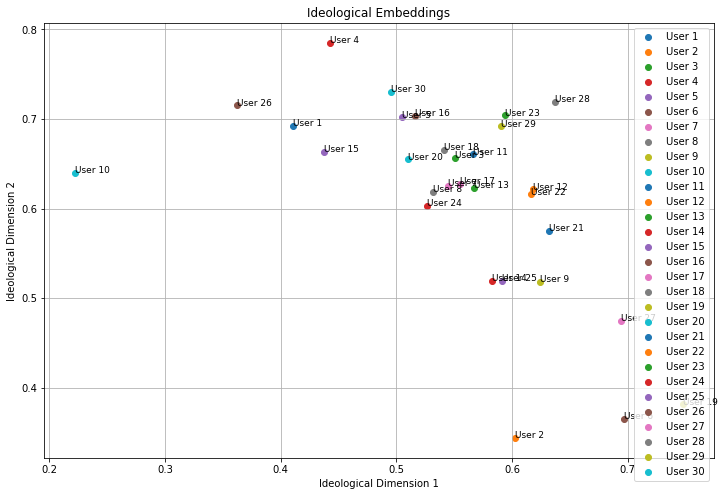

In [24]:
# Normalize the phi matrix for visualization
phi_normalized = normalize(phi)

# Visualize the embeddings
plt.figure(figsize=(12, 8))
for i, user_embedding in enumerate(phi_normalized):
    plt.scatter(user_embedding[0], user_embedding[1], label=f'User {i + 1}')
    plt.text(user_embedding[0], user_embedding[1], f'User {i + 1}', fontsize=9)

plt.xlabel('Ideological Dimension 1')
plt.ylabel('Ideological Dimension 2')
plt.title('Ideological Embeddings')
plt.legend()
plt.grid(True)
plt.show()
